<a href="https://colab.research.google.com/github/JeanBaptiste-dlb/ML_quick_intro/blob/main/ml_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Machine Learning Basel Hack 2022

This notebook aims to present some Machine Learning applications in a very constrained time. 

It will contain:
- A basic supervised classification and regression
- An unsupervised clustering
- A small Computer vision application
- A small Natural Language processing application


## imports

In [136]:
from IPython.display import clear_output
!pip install pandas
!pip install sklearn
clear_output(wait=True)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [137]:
import pandas as pd
import requests
from io import StringIO
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Regression
In the following example, we will try to predict the value of the houses in California based on some features. 
This problem is a regression as our label (the median house value in a district) take value in a continuous segment (approximation, intuition: there is way too many possible values for the label to consider it a classification problem). 

## get dataset

In [138]:
df_train=pd.read_csv("./sample_data/california_housing_train.csv")
df_test=pd.read_csv("./sample_data/california_housing_test.csv")

## I put the 2 dataset together because for Min Max normalization I want same scale between train and test. we will split again later.
df=pd.concat([df_train,df_test])
df=df.reset_index(drop=True)
display(df.head(5))
print(len(df))

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


20000


## Data preprocessing and preliminary data analysis

Feature normalization

In [139]:
df = df.dropna()
df["rooms_per_house"]=df["total_rooms"]/df["households"]
df["bedrooms_per_house"]=df["total_bedrooms"]/df["households"]
df["population_per_house"]= df["population"]/df["households"]

max value of population_per_house: 502.46153846153845


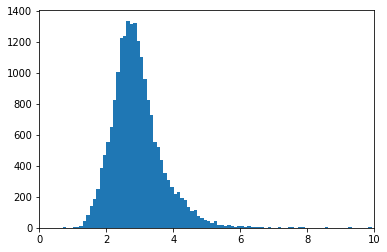

In [140]:
fig = plt.figure()
ax = plt.gca()
plt.hist(df.population_per_house, bins=5000)
ax.set_xlim([0,10]) 
print(f"max value of population_per_house: {max(df.population_per_house)}")
df.population_per_house = df.population_per_house.apply(lambda x: min(x,8) )

We observe that, here the max value is very high compared to most of the value. We may want to limit the max value by applying a threshold. We will do the same for the fields "rooms_per_house", "bedroom_per_house"

In [141]:
for i in ["rooms_per_house", "bedrooms_per_house", "population_per_house", "population"]:
  threshold = np.percentile(df[i], 99)
  df[i] = df[i].apply(lambda x: min(x, threshold)) ## 99 % of the data stays in range [0, 5.396] 

In [142]:
if ["total_rooms", "total_bedrooms", "population"] in list(df.columns):
  df.drop(columns=["total_rooms", "total_bedrooms", "population"], inplace=True)

for every field, we will apply a threshold at 99th percentile to reduce the range of values

In [143]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_house,bedrooms_per_house,population_per_house
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,-119.566172,35.626750,28.627750,2637.051550,537.991800,1403.859750,499.525450,3.872132,207082.716750,5.333331,1.076706,2.916411
std,2.003609,2.136141,12.582229,2176.314757,420.631119,973.313966,381.729517,1.900356,115557.055856,1.332782,0.162476,0.735717
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.333333,0.692308
25%,-121.790000,33.930000,18.000000,1451.000000,296.000000,788.000000,280.000000,2.562500,119800.000000,4.441216,1.005913,2.430380
50%,-118.490000,34.250000,29.000000,2126.000000,434.000000,1166.000000,409.000000,3.536000,179800.000000,5.232838,1.048710,2.819566
75%,-118.000000,37.710000,37.000000,3149.000000,647.000000,1724.000000,604.000000,4.745325,265000.000000,6.056697,1.099664,3.283609
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,5804.030000,6082.000000,15.000100,500001.000000,10.385260,2.153895,5.396033


We will normalize all value in a [0, 1] frame using MinMaxScaler

In [144]:
scaler=preprocessing.MinMaxScaler() 
columns_to_transform = list(df.columns)
columns_to_transform.remove("median_house_value")
df[columns_to_transform] = scaler.fit_transform(df[columns_to_transform])

In [145]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_house,bedrooms_per_house,population_per_house
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.476477,0.328029,0.541721,0.069462,0.083332,0.241485,0.081981,0.232565,207082.716750,0.470398,0.408321,0.472839
std,0.199563,0.227008,0.246710,0.057370,0.065275,0.167783,0.062774,0.131057,115557.055856,0.139718,0.089245,0.156412
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14999.000000,0.000000,0.000000,0.000000
25%,0.254980,0.147715,0.333333,0.038197,0.045779,0.135321,0.045881,0.142246,119800.000000,0.376876,0.369435,0.369510
50%,0.583665,0.181722,0.549020,0.055991,0.067194,0.200482,0.067094,0.209383,179800.000000,0.459863,0.392943,0.452250
75%,0.632470,0.549416,0.705882,0.082958,0.100248,0.296671,0.099161,0.292784,265000.000000,0.546230,0.420931,0.550904
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,500001.000000,1.000000,1.000000,1.000000


## Loss function

To define our success in predicting the label, we will need to define a metric. We could take the mean absolute error, but the root mean squared error is generally preferred if there are not many outliers (data points with extreme values).

In [146]:
## Definition of the root mean squared error 

def se(y_predicted: float, y_real: float) -> float:
  """
  The square loss for a label and the model prediction is the L2-norm computed as (squared difference between the label and prediction) 
  """
  return (y_predicted - y_real) ** 2

def rmse(ys_predicted: list, ys_real: list)-> float:
  """
  The root mean squared error is an aggregation of the squared error over an ensemble of predition. it is computed as the Square root of the average squared error for the set of evaluated points.
  """
  MSE = np.mean([se(y_predicted, y_real) for y_predicted, y_real in zip(ys_predicted, ys_real)]) 
  return np.sqrt(MSE)

def ae(y_predicted: float, y_real: float) -> float:
  return abs(y_predicted - y_real)

def mae(ys_predicted, ys_real):
  return np.mean([ae(y_predicted, y_real) for y_predicted, y_real in zip(ys_predicted, ys_real)]) 




print(rmse([1,0,1], [1,0,1]))
print(rmse([1,0,1], [1,1,1])) ## square root of 1/3
print(mae([1,0,1], [1,1,1])) ## 1/3


0.0
0.5773502691896257
0.3333333333333333


## Dataset splitting
To evaluate our model we need at least two dataset. One that is used to fit the model and one that is used to evaluate the performanse of the fitted model on unseeen data.

In [147]:
from sklearn.model_selection import train_test_split 

labels = df["median_house_value"]
features = df[columns_to_transform]

df_train, df_test, label_train, label_test = train_test_split(features, labels, test_size=0.1) ## A split with 10% of the data in the test set


## Modelling

A good first model to approach a regression problem is the linear regression as it is a very simple model that give you a first idea to the minimal performances you can expect. 

Given a set of data point X (dimension (#features, n_points)) 
and a label vector Y_true (of dimension (1, n_points))

The goal is to find the optimal coefficients we name a of dim (1, #features) and b of dimension 1 for our model:

Y_pred = aX + b  

such that: 
RMSE(Y_pred, Y_true) is minimal.

In [148]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(df_train, label_train)


In [149]:
print(f"value of a = {model.coef_}")
print(df_train.columns)
print(f"values of b={model.intercept_}")

value of a = [-428234.60245717 -410862.09136239   57725.16296783 -174833.29122188
   57549.72268674    8143.62514498  158973.88102883  619256.05255573
  -71034.89864288  162339.63902331 -163950.81469827]
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_house', 'bedrooms_per_house', 'population_per_house'],
      dtype='object')
values of b=407540.164757854


From this model we can have some first insights (high values positive or negative in the coefficients implies a high degree of correlation).

Here we can see the model is very highly corelated with the median income, longitude and latitude of the househod.

negative corelation in longitude and latitude means that housing is more expensive in the South-East of California.


A quick look at the map of california will show us that we are probably right (as South-East of California contains the coast area and cities that are known to be very expensive, such as Los Angeles).

We can now evaluate the RMSE fo this simple model

In [150]:
Y_pred = model.predict(df_test)

In [151]:
rmse(list(Y_pred), label_test)

66921.56472658105

In [152]:
mae(list(Y_pred), label_test)

49264.21571679909

On average our model has an error of ±49'224$ on the prediction of the median price in a district. 

In [153]:
## The evaluation can also be done entirely by scikit learn
## metric called R squared. https://en.wikipedia.org/wiki/Coefficient_of_determination
## Value between 0 and 1. 1 means model perfectly transfer to the test data. 
model.score(df_test, label_test)

0.6648359895041176

### More refined models

### Other linear model
+ Stochastic gradien descent (SGD)

### Non linear model
+ Multi layer perceptron with RELU activation


In [154]:
from sklearn.linear_model import SGDRegressor
model = SGDRegressor(max_iter=10000, tol=1e-5, alpha = 0.00005)
model = model.fit(df_train, label_train)

In [155]:
model.score(df_test, label_test)

0.6651150533400536

In [156]:
from sklearn.neural_network import MLPRegressor

In [157]:
model=MLPRegressor(hidden_layer_sizes=(15, 15, 10), random_state=42, max_iter=1000, alpha = 0.0005, learning_rate_init = 0.01, learning_rate="adaptive").fit(df_train, label_train)

In [158]:
model.score(df_test, label_test)

0.7105218799826059

## Supervised image classification

In this example we will used the infamous MNIST dataset. A dataset containing images of handwritten digits. The goal is to predict the hand written number from the image.

For the image classification problem, one of the most studied method is the Confolutional Neural Network (CNN) 

In [159]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [160]:
train_data[0][0].shape

torch.Size([1, 28, 28])

5


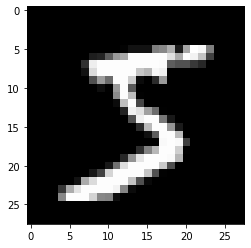

In [161]:
plt.imshow(np.array(train_data[0][0][0]), cmap='gray', vmin=0, vmax=1)
print(train_data[0][1])

In [162]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=2),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=2),
}

In [163]:

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [164]:
network = ConvNet()
optimizer = optim.SGD(network.parameters(), lr=0.005,
                      momentum=0.5)

In [165]:
log_interval=200
train_losses=[]
train_counter=[]
device = torch.device(
    "cuda:0"
    if torch.cuda.is_available()
    else "cpu"
)

loss_func = nn.CrossEntropyLoss()   
loss_func

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(loaders["train"]):
    data.to(device)
    target.to(device)
    optimizer.zero_grad()
    output = network(data)
    loss = loss_func(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(loaders["train"]) * len(data),
        100. * batch_idx / len(loaders["train"]), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(data)))
      
def test():
    # Test the model
    network.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output = network(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    return accuracy


In [ ]:
test_losses=[]
for i in range(10):
  train(i)
  test_losses.append(test())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.313043
Train Epoch: 0 [20000/60000 (200%)]	Loss: 2.308141
Train Epoch: 0 [40000/60000 (400%)]	Loss: 2.250141
Test Accuracy of the model on the 10000 test images: 0.59
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.962421
Train Epoch: 1 [20000/60000 (200%)]	Loss: 1.286790
Train Epoch: 1 [40000/60000 (400%)]	Loss: 0.961000
Test Accuracy of the model on the 10000 test images: 0.84
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.774436
Train Epoch: 2 [20000/60000 (200%)]	Loss: 0.721335
Train Epoch: 2 [40000/60000 (400%)]	Loss: 0.480686
Test Accuracy of the model on the 10000 test images: 0.92
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.639835
Train Epoch: 3 [20000/60000 (200%)]	Loss: 0.833853
Train Epoch: 3 [40000/60000 (400%)]	Loss: 0.602207
Test Accuracy of the model on the 10000 test images: 0.92
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.364084
Train Epoch: 4 [20000/60000 (200%)]	Loss: 0.442311
Train Epoch: 4 [40000/60000 (400%)]	Loss: 0.488282
Test Accuracy of the model on the

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot()